In [1]:
import sympy as sp
import tensorflow as tf
import tensorflow.python.keras.backend as K
import tensorflow_probability as tfp

import MLGeometry as mlg
from MLGeometry import bihomoNN as bnn

import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)
tf.random.set_seed(42)

Hello from BihomoNN! Arbitrary dimension!


In [2]:
# Matplotlib options
%matplotlib inline
#%matplotlib notebook
plt.style.use('dark_background')
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = [4, 2]
plt.rcParams['text.usetex'] = True

## Modules

In [3]:
# Plot training get_loss_hist
def plot_train_hist(model, val=False, y_scale='linear'):
    x1 = np.arange(1, len(model.get_loss_hist())+1)
    plt.scatter(x1, model.get_loss_hist(), marker='.', label='Training loss' )
    #if val:
    #    plt.scatter(x1, model.get_loss_hist['val_loss'], marker='.', label='Validation loss')
    plt.xlabel('Training epochs')
    plt.ylabel('Loss')
    plt.yscale(y_scale)
    plt.legend()
    print("Final loss: ", model.get_loss_hist()[-1])
    return plt.show()

In [4]:
def cal_total_loss(dataset, kahler_pot, loss_function, c1):
    total_loss = tf.constant(0, dtype=tf.float32)
    total_mass = tf.constant(0, dtype=tf.float32)
    
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(dataset):
        curv_tr = curvature_trace(points, kahler_pot, hermitian_met, mass)
        mass_sum = tf.reduce_sum(mass)
        total_loss += loss_func(c1, curv_tr, mass)  * mass_sum
        total_mass += mass_sum
    total_loss = total_loss / total_mass

    return total_loss.numpy()



Networks for $\mathcal{O}_X(1)$, $\mathcal{O}_X(2)$, $\mathcal{O}_X(4)$ respectively.

\begin{itemize}
\item "dim" is the number of projective coordinates of points on the CY hypersurface.
\item "vec" is a vector giving the number of neurons for layers 1 through d-1
\item "rank" is the rank of the vector bundle -- so far should just be 1
\end{itemize}

In [5]:
class Hermitian_metric_O1(tf.keras.Model):
    def __init__(self, dim, rank, vec):
        super(Hermitian_metric_O1, self).__init__()
        self.dim = dim
        self.rank = rank
        self.vec = vec
        self.loss_hist = []
        print("Bundle rank", self.rank)
        self.bihomogeneous = bnn.Bihomogeneous(self.dim)
        self.layer1 = bnn.Dense(self.dim**2, self.rank)
    
    def append_loss(self, loss):
        self.loss_hist.append([loss])
    
    def get_loss_hist(self):
        return self.loss_hist
    
    def call(self, inputs):
        x = self.bihomogeneous(inputs)
        x = tf.math.log(x)
        return x
    

class Hermitian_metric_O2(tf.keras.Model):
    def __init__(self, dim, rank, vec):
        super(Hermitian_metric_O2, self).__init__()
        self.dim = dim
        self.rank = rank
        self.vec = vec
        self.loss_hist = []
        print("Bundle rank", self.rank)
        self.bihomogeneous = bnn.Bihomogeneous(self.dim)
        self.layer1 = bnn.Dense(self.dim**2, self.vec[0], activation=tf.square)
        self.layer2 = bnn.Dense(self.vec[0], self.rank)
        
    def append_loss(self, loss):
        self.loss_hist.append([loss])
    
    def get_loss_hist(self):
        return self.loss_hist
    
    def call(self, inputs):
        x = self.bihomogeneous(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        x = tf.math.log(x)
        return x
  

class Hermitian_metric_O4(tf.keras.Model):
    def __init__(self, dim, rank, vec):
        super(Hermitian_metric_O4, self).__init__()
        self.dim = dim
        self.rank = rank
        self.vec = vec
        self.loss_hist = []
        print("Bundle rank", self.rank)
        self.bihomogeneous = bnn.Bihomogeneous(self.dim)
        self.layer1 = bnn.Dense(dim**2, self.vec[0], activation=tf.square)
        self.layer2 = bnn.Dense(self.vec[0], self.vec[1], activation=tf.square)
        self.layer3 = bnn.Dense(self.vec[1], self.rank)
    
    def append_loss(self, loss):
        self.loss_hist.append([loss])
    
    def get_loss_hist(self):
        return self.loss_hist
    
    def call(self, inputs):
        x = self.bihomogeneous(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = tf.math.log(x)
        return x

## Curvature calculation

\begin{itemize}
\item Issue with normalization needs to be fixed here, in weighted_loss
\item Other issue is taking inverse of K\"ahler metric or curvature tensor when calculating $g^{i\bar{j}} F_{i\bar{j}}$
\end{itemize}

In [6]:
def weighted_MAPE(y_true, y_pred, mass):
    weights = mass / K.sum(mass)
    return K.sum(K.abs(y_true - y_pred) / tf.cast(y_true, tf.float32) * weights)

def weighted_loss(y_true, y_pred, mass):
    weights = mass /K.sum(mass)
    #print(4"loss1:", K.sum( K.abs(y_pred - y_true) * weights))
    #print("loss2:", K.sum( K.abs(y_pred - y_true) * weights) / K.sum(weights))
    #return K.abs( K.sum( (y_pred - y_true) * weights) ) / K.sum(weights) 
    return K.sum( K.abs(y_pred - y_true) * weights) / K.sum(weights)

@tf.function
def curvature_trace(points, hermitian_met, kahler_pot, herm_metric, mass):
    kahler_metric = mlg.complex_math.complex_hessian(tf.math.real(kahler_pot(points)), points)
    #print("kahler_metric: ", kahler_metric)
    #inv_kahler_metric = tf.linalg.inv(kahler_metric)
    #print("inverse kahler_metric: ", inv_kahler_metric)
    curvature = mlg.complex_math.complex_hessian(tf.math.real(herm_metric(points)), points)
    #print("curvature", curvature)
    #inv_curvature = tf.linalg.inv(curvature)
    curvature_trace = tf.linalg.trace(tf.matmul(kahler_metric, curvature) )
    # print("contraction", tf.matmul(kahler_metric, curvature) )
    # print("curvature_trace: ", curvature_trace)
    return curvature_trace


## Generate points and load Kahler potential network

In [7]:
# Define K3 surface
z0, z1, z2, z3 = sp.symbols('z0, z1, z2, z3')
Z = [z0, z1, z2, z3]
f = z0**4 + z1**4 + z2**4 + z3**4 + 0.5*z0*z1*z2*z3
#f = z0**4 + z1**4 + z2**4 + z3**4 # Switch to Fermat surface
f

z0**4 + 0.5*z0*z1*z2*z3 + z1**4 + z2**4 + z3**4

In [8]:
# Create training and testing set
n_pairs = 10000
HS_train = mlg.hypersurface.Hypersurface(Z, f, n_pairs)
HS_test = mlg.hypersurface.Hypersurface(Z, f, n_pairs)
train_set = mlg.tf_dataset.generate_dataset(HS_train)
test_set = mlg.tf_dataset.generate_dataset(HS_test)
train_set = train_set.shuffle(HS_train.n_points).batch(1000)
test_set = test_set.shuffle(HS_test.n_points).batch(1000)

In [9]:
# Load CY metric/Kahler potential
kahler_pot = tf.keras.models.load_model("K3_2_kahler_pot")
# kahler_pot = tf.keras.models.load_model("K3_fermat_kahler_pot") # Switch to fermat curve

## O(1)

This has stopped working due to no gradients occuring - $\mathcal{O}_X(2)$ is the first that works

In [20]:
# Define and train model for hermitian metric
hermitian_met = Hermitian_metric_O1(4, 1, [])
print("Hermitian metric G network defined")
c1 = tf.constant(1., shape=(1000), dtype=tf.complex64)
optimizer = tf.keras.optimizers.Adam()
loss_func = weighted_MAPE 
loss_hist = []
max_epochs = 100 
epoch = 0
#print("Beginning training")
while epoch < max_epochs:
    epoch = epoch + 1
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(train_set):
        with tf.GradientTape() as tape:
            # det_omega = nf.volume_form(points, Omega_Omegabar, mass, restriction, kahler_pot)
            curv_tr = curvature_trace(points, kahler_pot, hermitian_met, mass)
            #print("calculate curv_tr: ", curv_tr)
            #print("c1: ", c1)
            loss = loss_func(curv_tr, c1, mass)
            grads = tape.gradient(loss, hermitian_met.trainable_weights)
        optimizer.apply_gradients(zip(grads, hermitian_met.trainable_weights))
    #if epoch % 50 == 0:
    #    print("epoch %d: loss = %.7f" % (epoch, loss))
    loss_hist.append(loss)
    hermitian_met.append_loss(loss)
    print("epoch %d: loss = %.7f" % (epoch, loss))

Bundle rank 1
Hermitian metric G network defined


ValueError: No gradients provided for any variable: ['Variable:0'].

Final loss:  ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=2122.4229>])


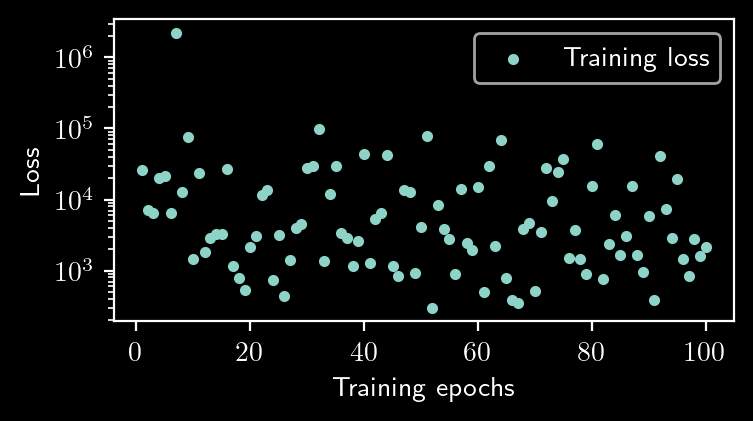

In [22]:
plot_train_hist(hermitian_met, y_scale='log')

## O(2) -- 2 layer network

In [10]:
# Define and train model for hermitian metric
hermitian_met = Hermitian_metric_O2(4, 1, [100])
print("Hermitian metric G network defined")
c1 = tf.constant(2., shape=(1000), dtype=tf.complex64)
optimizer = tf.keras.optimizers.Adam()
loss_func = weighted_loss  
loss_hist = []
max_epochs = 100 
epoch = 0
#print("Beginning training")
while epoch < max_epochs:
    epoch = epoch + 1
    # print("epoch: ", epoch)
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(train_set):
        # print("mass: ", mass)
        with tf.GradientTape() as tape:
            curv_tr = curvature_trace(points, kahler_pot, hermitian_met, mass)
            loss = loss_func(c1, curv_tr, mass) 
            grads = tape.gradient(loss, hermitian_met.trainable_weights)
        optimizer.apply_gradients(zip(grads, hermitian_met.trainable_weights))
    #if epoch % 50 == 0:
    #    print("epoch %d: loss = %.7f" % (epoch, loss))
    loss_hist.append(loss)
    hermitian_met.append_loss(loss)
    print("epoch %d: loss = %.7f" % (epoch, loss))

Bundle rank 1
Hermitian metric G network defined


/home/rehandeen/miniconda3/envs/ml/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradients/boolean_mask/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


epoch 1: loss = 1.8530517
epoch 2: loss = 1.7761823
epoch 3: loss = 1.9177244
epoch 4: loss = 2.1445618
epoch 5: loss = 1.9240010
epoch 6: loss = 1.8159497
epoch 7: loss = 1.8918860
epoch 8: loss = 1.8607010
epoch 9: loss = 1.8071690
epoch 10: loss = 1.8703868
epoch 11: loss = 1.9045316
epoch 12: loss = 1.8840197
epoch 13: loss = 1.9351382
epoch 14: loss = 1.8825184
epoch 15: loss = 1.8489228
epoch 16: loss = 1.8160678
epoch 17: loss = 1.8275738
epoch 18: loss = 1.9263090
epoch 19: loss = 2.1647797
epoch 20: loss = 1.9420241
epoch 21: loss = 1.8876498
epoch 22: loss = 1.7746891
epoch 23: loss = 1.8622558
epoch 24: loss = 69.0447388
epoch 25: loss = 1.8927996
epoch 26: loss = 67.6524811
epoch 27: loss = 2.2623255
epoch 28: loss = 2.7635796
epoch 29: loss = 1.8788116
epoch 30: loss = 2.7704821
epoch 31: loss = 1.8360044
epoch 32: loss = 1.8098383
epoch 33: loss = 1.7904291
epoch 34: loss = 1.9492515
epoch 35: loss = 2.8494475
epoch 36: loss = 1.9189346
epoch 37: loss = 2.8535781
epoch 38

Final loss:  ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=1.9341935>])


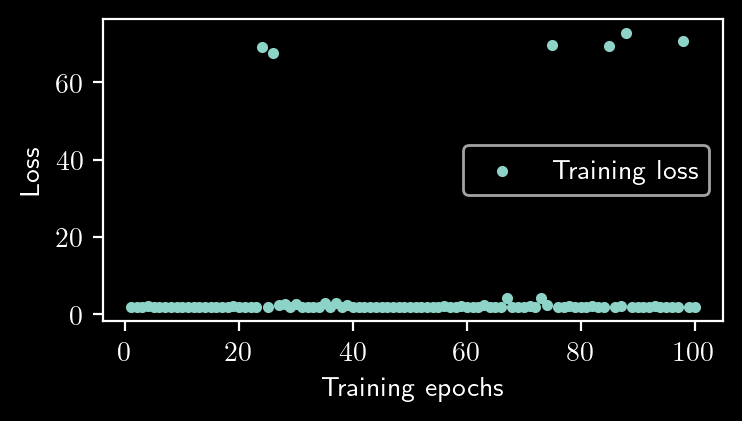

In [13]:
plot_train_hist(hermitian_met, y_scale='linear')

Validation/test data

In [14]:
cal_total_loss(test_set, hermitian_met, kahler_pot, weighted_loss, c1)

2.2119193

## O(4) -- 3 layer network

Seems to train reasonably well compared to the others, 

In [15]:
# Define and train model for hermitian metric
hermitian_met = Hermitian_metric_O4(4, 1, [10,100])
print("Hermitian metric G network defined")
c1 = tf.constant(4., shape=(1000), dtype=tf.complex64)
optimizer = tf.keras.optimizers.Adam()
loss_func = weighted_loss 
max_epochs = 100 
epoch = 0
while epoch < max_epochs:
    epoch = epoch + 1
    for step, (points, Omega_Omegabar, mass, restriction) in enumerate(train_set):
        with tf.GradientTape() as tape:
            curv_tr = curvature_trace(points, kahler_pot, hermitian_met, mass)
            #print("calculate curv_tr: ", curv_tr)
            #print("c1: ", c1)
            loss = loss_func(c1, curv_tr, mass) 
            # print("calculated loss: ", loss)
            grads = tape.gradient(loss, hermitian_met.trainable_weights)
        optimizer.apply_gradients(zip(grads, hermitian_met.trainable_weights))
    #if epoch % 50 == 0:
    #    print("epoch %d: loss = %.7f" % (epoch, loss))
    hermitian_met.append_loss(loss)
    print("epoch %d: loss = %.7f" % (epoch, loss))

Bundle rank 1
Hermitian metric G network defined
epoch 1: loss = 39.1416168
epoch 2: loss = 4.8356481
epoch 3: loss = 5.1060371
epoch 4: loss = 4.9163494
epoch 5: loss = 8.4873629
epoch 6: loss = 5.5122018
epoch 7: loss = 5.5622468
epoch 8: loss = 5.2413821
epoch 9: loss = 7.6594210
epoch 10: loss = 5.4671988
epoch 11: loss = 15.8508539
epoch 12: loss = 4.7944870
epoch 13: loss = 77.4971542
epoch 14: loss = 5.1881475
epoch 15: loss = 7.3809376
epoch 16: loss = 4.9800577
epoch 17: loss = 4.7370062
epoch 18: loss = 16.2137451
epoch 19: loss = 51.6156998
epoch 20: loss = 4.9800963
epoch 21: loss = 4.9426069
epoch 22: loss = 7.3301363
epoch 23: loss = 4.9958892
epoch 24: loss = 7.2246909
epoch 25: loss = 6.4574966
epoch 26: loss = 4.6439958
epoch 27: loss = 4.7956567
epoch 28: loss = 66.7174606
epoch 29: loss = 5.6579127
epoch 30: loss = 4.8684931
epoch 31: loss = 5.1801181
epoch 32: loss = 7.0541368
epoch 33: loss = 5.0552402
epoch 34: loss = 6.4329433
epoch 35: loss = 5.2751637
epoch 36:

Final loss:  ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=5.2278247>])


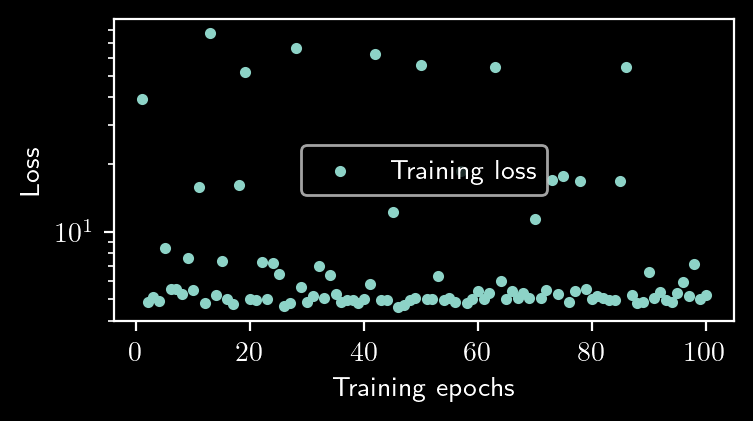

In [19]:
plot_train_hist(hermitian_met, y_scale='log')

Validation/test data

In [18]:
cal_total_loss(test_set, hermitian_met, kahler_pot, weighted_loss, c1)

6.729216